<a href="https://colab.research.google.com/github/jamestheengineer/data-science-from-scratch-Python/blob/master/Chapter_21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Scraping the web. We'll use a couple external packages (i.e., not from scratch)
#!pip install beautifulsoup4 requests html5lib

# NLP

data = [ ("big data", 100, 15), ("Hadoop", 95, 25), ("Python", 75, 50),
         ("R", 50, 40), ("machine learning", 80, 20), ("statistics", 20, 60),
         ("data science", 60, 70), ("analytics", 90, 3),
         ("team player", 85, 85), ("dynamic", 2, 90), ("synergies", 70, 0),
         ("actionable insights", 40, 30), ("think out of the box", 45, 10),
         ("self-starter", 30, 50), ("customer focus", 65, 15),
         ("thought leadership", 35, 35)]


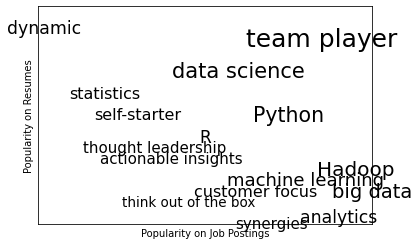

In [4]:
from matplotlib import pyplot as plt

def text_size(total: int) -> float:
  """equals 8 if total is 0, 28 if total is 200"""
  return 8 + total / 200 * 20

for word, job_popularity, resume_popularity in data:
  plt.text(job_popularity, resume_popularity, word, 
           ha='center', va='center',
           size=text_size(job_popularity + resume_popularity))

plt.xlabel("Popularity on Job Postings")
plt.ylabel("Popularity on Resumes")
plt.axis([0,100,0,100])
plt.xticks([])
plt.yticks([])
plt.show()

In [5]:
# Make a bunch of webpages example
def fix_unicode(text: str) -> str:
    return text.replace(u"\u2019", "'")

import re
from bs4 import BeautifulSoup
import requests

url = "https://www.oreilly.com/ideas/what-is-data-science"
html = requests.get(url).text
soup = BeautifulSoup(html, 'html5lib')

content = soup.find("div", "main-post-radar-content")   # find right content div
regex = r"[\w']+|[\.]"                       # matches a word or a period
document = []

for paragraph in content("p"):
    words = re.findall(regex, fix_unicode(paragraph.text))
    document.extend(words)

print(document)

['Weâ', 've', 'all', 'heard', 'it', 'according', 'to', 'Hal', 'Varian', 'statistics', 'is', 'the', 'next', 'sexy', 'job', '.', 'Five', 'years', 'ago', 'in', 'What', 'is', 'Web', '2', '.', '0', 'Tim', 'Oâ', 'Reilly', 'said', 'that', 'â', 'data', 'is', 'the', 'next', 'Intel', 'Inside', '.', 'â', 'But', 'what', 'does', 'that', 'statement', 'mean', 'Why', 'do', 'we', 'suddenly', 'care', 'about', 'statistics', 'and', 'about', 'data', 'In', 'this', 'post', 'I', 'examine', 'the', 'many', 'sides', 'of', 'data', 'science', 'â', 'the', 'technologies', 'the', 'companies', 'and', 'the', 'unique', 'skill', 'sets', '.', 'Join', 'the', "O'Reilly", 'online', 'learning', 'platform', '.', 'Get', 'a', 'free', 'trial', 'today', 'and', 'find', 'answers', 'on', 'the', 'fly', 'or', 'master', 'something', 'new', 'and', 'useful', '.', 'The', 'web', 'is', 'full', 'of', 'â', 'data', 'driven', 'apps', '.', 'â', 'Almost', 'any', 'e', 'commerce', 'application', 'is', 'a', 'data', 'driven', 'application', '.', 'Ther

In [6]:
from collections import defaultdict
import random

transitions = defaultdict(list)
for prev, current in zip(document, document[1:]):
  transitions[prev].append(current)

def generate_using_bigrams() -> str:
  current = "." # this means the next word will start a sentence
  result = []
  while True:
    next_word_candidates = transitions[current] # bigrams (current, _)
    current = random.choice(next_word_candidates) # choose one at random
    result.append(current) # append it to results
    if current == ".": return " ".join(result) # if "." we're done

# You can make sentences less gibberishly by using trigrams instead of bigrams
trigram_transitions = defaultdict(list)
starts = []
for prev, current, next in zip(document, document[1:], document[2:]):
  if prev == ".":  # if the previous word was a period
    starts.append(current) # then this is a start word
  
  trigram_transitions[(prev, current)].append(next)

def generate_using_trigrams() -> str:
  current = random.choice(starts)
  prev = "."
  result = [current]
  while True:
    next_word_candidates = trigram_transitions[(prev, current)]
    next_word = random.choice(next_word_candidates)

    prev, current = current, next_word
    result.append(current)

    if current == ".":
      return " ".join(result)

In [7]:
# Grammars
from typing import List, Dict

# Type alias to refer to grammars later
Grammar = Dict[str, List[str]]

grammar = {
    "_S"  : ["_NP _VP"],
    "_NP" : ["_N",
             "_A _NP _P _A _N"],
    "_VP" : ["_V",
             "_V _NP"],
    "_N"  : ["data science", "Python", "regression"],
    "_A"  : ["big", "linear", "logistic"],
    "_P"  : ["about", "near"],
    "_V"  : ["learns", "trains", "tests", "is"]
}

def is_terminal(token: str) -> bool:
  return token[0] != "_"

def expand(grammar: Grammar, tokens: List[str]) -> List[str]:
  for i, token in enumerate(tokens):
    # if this is a terminal token, skip it
    if is_terminal(token): continue

    # Otherwise, it's a nonterminal token, 
    # so we need to choose a replacement at random.
    replacement = random.choice(grammar[token])

    if is_terminal(replacement):
      tokens[i] = replacement
    else:
      # Replacement be another nonterminal
      tokens = tokens[:i] + replacement.split() + tokens[(i+1):]
    
    # now call expand on the new list of tokens
    return expand(grammar, tokens)
  # If we get here, we had all terminals and are done
  return tokens

def generate_sentence(grammar: Grammar) -> List[str]:
  return expand(grammar, ["_S"])

In [8]:
print(generate_sentence(grammar))

['big', 'regression', 'near', 'logistic', 'Python', 'tests']


In [9]:
# Gibbs sampling - a way to sample hard to sample distributions

# Rolling a dice example
from typing import Tuple
import random

def roll_a_die() -> int:
  return random.choice([1,2,3,4,5,6])

def direct_sample() -> Tuple[int, int]:
  d1 = roll_a_die()
  d2 = roll_a_die()
  return d1, d1 + d2

def random_y_given_x(x: int) -> int:
  """equally likely to be x+1, x+2, ..., x+6"""
  return x + roll_a_die()

def random_x_given_y(y: int) -> int:
  if y <= 7:
    # if the total is 7 or less, the first die is equally likely to be
    # 1, 2, ...., (total - 1)
    return random.randrange(1, y)
  else:
    # if the total is 7 or more, the first die is equally likely to be
    # (total - 6), (total - 5), ..., 6
    return random.randrange(y - 6, 7)

def gibbs_sample(num_iters: int = 100) -> Tuple[int, int]:
  x, y = 1, 2 # doesn't really matter
  for _ in range(num_iters):
    x = random_x_given_y(y)
    y = random_y_given_x(x)
  return x, y

def compare_distributions(num_samples: int = 1000) -> Dict[int, List[int]]:
  counts = defaultdict(lambda: [0,0])
  for _ in range(num_samples):
    counts[gibbs_sample()][0] += 1
    counts[direct_sample()][1] += 1
  return counts

In [10]:
def sample_from(weights: List[float]) -> int:
  """returns i with probability weights[i] / sum(weights)"""
  total = sum(weights)
  rnd = total * random.random() # uniform between 0 and total
  for i, w in enumerate(weights):
    rnd -= w      # return the smallest i such that
    if rnd <= 0: return i # weights[0] + ... + weights[i] >= rnd

from collections import Counter

# Draw 1000 times and count
draws = Counter(sample_from([0.1, 0.1, 0.8]) for _ in range(1000))
assert 10 < draws[0] < 190 # should be ~10%, this is really a loose test
assert 10 < draws[1] < 190 # should be ~10%, this is really a loose test
assert 650 < draws[2] < 950 # should be ~80%, this is a really loose test
assert draws[0] + draws[1] + draws[2] == 1000

In [11]:
documents = [
    ["Hadoop", "Big Data", "HBase", "Java", "Spark", "Storm", "Cassandra"],
    ["NoSQL", "MongoDB", "Cassandra", "HBase", "Postgres"],
    ["Python", "scikit-learn", "scipy", "numpy", "statsmodels", "pandas"],
    ["R", "Python", "statistics", "regression", "probability"],
    ["machine learning", "regression", "decision trees", "libsvm"],
    ["Python", "R", "Java", "C++", "Haskell", "programming languages"],
    ["statistics", "probability", "mathematics", "theory"],
    ["machine learning", "scikit-learn", "Mahout", "neural networks"],
    ["neural networks", "deep learning", "Big Data", "artificial intelligence"],
    ["Hadoop", "Java", "MapReduce", "Big Data"],
    ["statistics", "R", "statsmodels"],
    ["C++", "deep learning", "artificial intelligence", "probability"],
    ["pandas", "R", "Python"],
    ["databases", "HBase", "Postgres", "MySQL", "MongoDB"],
    ["libsvm", "regression", "support vector machines"]
]